# Requirements

In [ ]:
!pip install -q datasets transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.5 MB/s eta 0:00:00


# Imports

In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
import re
from datasets import Dataset
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import torch.nn.functional as F

In [ ]:
import torch

# Check if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Print the device being used
print(f"Using device: {device}")

Using device: cuda


# Dataset

## 1. Load Racism Dataset from "sakren/twitter_racism_dataset" repo

In [ ]:
race_df = pd.read_csv(r'dataset/Huggingface/twitter_racism_parsed_dataset.csv')
race_df.head()

,index,id,Text,Annotation,oh_label
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,5.766462e+17,5.766462e+17,"Finally I'm all caught up, and that sudden dea...",none,0
4,5.713492e+17,5.713492e+17,@carolinesinders @herecomesfran *hugs*,none,0


### Select Two Columns, and Rename one column

In [ ]:
race_df = race_df[['Text', 'oh_label']]
race_df = race_df.rename(columns={"oh_label": "target"})
race_df.head()

,Text,target
0,@AAlwuhaib1977 Muslim mob violence against Hin...,1
1,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,0
2,@jncatron @isra_jourisra @AMPalestine Islamoph...,1
3,"Finally I'm all caught up, and that sudden dea...",0
4,@carolinesinders @herecomesfran *hugs*,0


In [ ]:
race_df.columns
race_df['target'].value_counts()

target
0    11501
1     1970
Name: count, dtype: int64

### Save `target=1` (Racism) data to `racism_df.csv`

In [ ]:
df_racism = race_df[race_df['target']==1]
df_racism.to_csv('generated_dataset/racism.csv', index=False)

### Save `target=0` (non-hate) data to `non-hate.csv`

In [ ]:
df_racism = race_df[race_df['target']==0]
df_racism.to_csv('generated_dataset/non-hate.csv', index=False)

## 2. Identify Xenophobic Tweets using Key Phrases

### Detecting Xenophobic Phrases in Text

This code identifies the presence of xenophobic phrases in text, such as tweets. It defines a list of common xenophobic phrases and checks if a given text contains any of them. The results are then printed, providing insight into the prevalence of xenophobic content in the dataset.

The code can be used as a starting point for building tools to detect and address xenophobic language in online platforms.

In [ ]:
# Read whole data
df_xeno = pd.read_csv('dataset/Kaggle/Xenophobia.csv', delimiter=',', encoding='latin1')
df_xeno.dataframeName = 'Xenophobia.csv'
nRow, nCol = df_xeno.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 4768409 rows and 9 columns


In [ ]:
xenophobic_phrases = ["white power", "white pride", "white supremacy", "brown people", "brown threat",
                      "invade our country", "go back to your country", "not welcome here", "you don't belong",
                      "take our jobs", "steal our jobs", "immigrant invasion", "foreign threat",  "alien invasion",
                      "deport them all", "close the borders", "ban the Muslims", "Christian nation", "Jewish conspiracy",
                      "ethnic cleansing", "race war", "nationality conflict", "we need to enforce our borders",
                      "learn to speak english", "are terrorists", "where are you really from", "are spreading virus",
                      "i’m not like other", "illegal alien", "illegal immigrant", "illegal immigration", "send her back",
                      "send them back", "illegal criminal"]


# Function to check if a tweet contains any of the key phrases
def is_xenophobic(tweet):
    if isinstance(tweet, str):
        for phrase in xenophobic_phrases:
            if re.search(phrase, tweet.lower(), re.IGNORECASE):
                return True
    return False


# Read the CSV file and process the tweets
df_xeno = pd.read_csv('dataset/Kaggle/Xenophobia.csv', delimiter=',', encoding='latin1')

# select only text column
df_xeno = df_xeno[['text']]
df_xeno['text'] = df_xeno['text'].astype(str)

df_xeno['is_xenophobic'] = df_xeno['text'].apply(lambda x : is_xenophobic(x))

# Print the results
print(df_xeno['is_xenophobic'].value_counts())

### Save `target=2` (Xenophobic) data to `xenophobic_df.csv`

In [ ]:
# Create a new DataFrame with only the xenophobic rows
df_xenophobic = df_xeno[df_xeno['is_xenophobic']]

# Add a 'target' column with a value of 2 (label=2)
df_xenophobic = df_xenophobic.rename(columns={"is_xenophobic": "target"})
df_xenophobic['target'] = 2

df_xenophobic.to_csv('generated_dataset/xenophobic_df.csv', index=False)

## 3. Read new generated dataframes

#### 1. Read `racism` dataset

In [ ]:
df_racism = pd.read_csv('generated_dataset/racism.csv')
df_racism = df_racism.rename(columns={"Text": "text"})
print(f'The length of dataset is: {len(df_racism)}')

df_racism.head()

The length of dataset is: 1970


,text,target
0,@AAlwuhaib1977 Muslim mob violence against Hin...,1
1,@jncatron @isra_jourisra @AMPalestine Islamoph...,1
2,@HuffPostRelig Islam invaded and conquered 2/3...,1
3,@semzyxx Do you approve of your pedophile prop...,1
4,@watan71969 @geeky_zekey Problem with vile Mus...,1


In [ ]:
df_racism['target'].value_counts()

target
1    1970
Name: count, dtype: int64

#### 2. Read `xenophobic` dataset

In [ ]:
df_xeno = pd.read_csv('generated_dataset/xenophobic.csv')
print(f'The length of dataset is: {len(df_xeno)}')

df_xeno.head()

The length of dataset is: 1955


,text,target
0,This is the problem: your healthcare system ge...,2
1,Wait so.... all these Italians are Iranians th...,2
2,"I hope when (if) all this will be over, bigots...",2
3,"does not register the victims, to avoid convi...",2
4,28 million Americans donât have health insur...,2


In [ ]:
df_xeno['target'].value_counts()

target
2    1955
Name: count, dtype: int64

#### 3. Read `Non-hate` dataset

In [ ]:
df_NonHate = pd.read_csv('generated_dataset/non-hate.csv')
df_NonHate = df_NonHate.rename(columns={"Text": "text"})
print(f'The length of dataset is: {len(df_NonHate)}')
df_NonHate.head()

The length of dataset is: 11501


,text,target
0,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,0
1,"Finally I'm all caught up, and that sudden dea...",0
2,@carolinesinders @herecomesfran *hugs*,0
3,"Please, PLEASE start using ""is your discernmen...",0
4,@aymannathem As soon as ISIS chased all the mi...,0


In [ ]:
df_NonHate['target'].value_counts()

target
0    11501
Name: count, dtype: int64

##### The neutral dataset is **{11501}**, but I want to select only **2,000** rows with the **longest sentences** from this DataFrame

In [ ]:
df_NonHate['text_len'] = df_NonHate['text'].str.len()

# Sort the DataFrame by the length of the text in descending order
df_NonHate = df_NonHate.sort_values('text_len', ascending=False)

# Select the first 2,000 rows
df_NonHate = df_NonHate.head(2000)
df_NonHate.head()

,text,target,text_len
2804,My fav #MKR teams so far are definitely: \nEva...,0,162
3524,RT @Lunchaballin: HOT SINGLES ARE IN YOUR AREA...,0,149
6002,RT @fangirlerin: 17? as much as i didn't like ...,0,148
6614,Talked about Weev &amp; full disclosure mailin...,0,148
5021,LMAO... #kat&amp;andre #mykitchenrules #MKR ...,0,148


##### Select `text`, and `target` columns in neutral dataframe

In [ ]:
df_NonHate = df_NonHate[['text', 'target']]
df_NonHate.head()

,text,target
2804,My fav #MKR teams so far are definitely: \nEva...,0
3524,RT @Lunchaballin: HOT SINGLES ARE IN YOUR AREA...,0
6002,RT @fangirlerin: 17? as much as i didn't like ...,0
6614,Talked about Weev &amp; full disclosure mailin...,0
5021,LMAO... #kat&amp;andre #mykitchenrules #MKR ...,0


#### Merging three dataframes and save it to `combined.csv` file

In [ ]:
concatenated_df = pd.concat([df_racism, df_xeno, df_NonHate], ignore_index=True)

# Shuffle and save it
concatenated_df = concatenated_df.sample(frac=1).reset_index(drop=True)
concatenated_df.to_csv('generated_dataset/concatenated.csv', index=False)
concatenated_df.head()

,text,target
0,That moment when you've been drinking &amp; yo...,0
1,Are we really stupid as a country &amp; govt? ...,2
2,Sometimes my mom says such stupid shit that I ...,0
3,@Qoloob4 @Vandaliser @sajid_fairooz @IsraeliRe...,1
4,@IndianExpress @hstapanghosh It's called repro...,1


In [ ]:
concatenated_df['target'].value_counts()

target
0    2000
1    1970
2    1955
Name: count, dtype: int64

In [ ]:
len(df_racism) + len(df_xeno) + len(df_NonHate) == len(concatenated_df)

True

# Preprocess data (`concatenated.csv`)

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load the English language model
nlp = spacy.load('en_core_web_sm')

def clean_text_and_dataset(df):
    """
    Clean the given DataFrame by performing the following steps:
    1. Remove mentions (@username)
    2. Remove URLs
    3. Convert text to lowercase
    4. Remove non-alphanumeric characters
    5. Remove stop words
    6. Perform stemming
    7. Perform lemmatization
    8. Strip any leading/trailing whitespace

    Returns the cleaned DataFrame.
    """

    def clean_text(text):
        """
        Clean the given text using the steps described above.
        """
        # Remove mentions
        text = re.sub(r'@\w+', '', text)

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Convert to lowercase
        text = text.lower()

        # Remove non-alphanumeric characters
        text = re.sub(r'[^\w\s]', '', text)

        # Remove stop words
        doc = nlp(text)
        text = ' '.join([token.text for token in doc if not token.is_stop])

        # Perform stemming
        text = ' '.join([token.lemma_ for token in doc])

        # Perform lemmatization
        text = ' '.join([token.lemma_ for token in doc])

        # Strip whitespace
        text = text.strip()

        return text

    # Apply the clean_text function to the 'text' column
    df['text'] = df['text'].apply(clean_text)

    return df

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
# Clean the concatenated dataset
cleaned_df = pd.read_csv('generated_dataset/concatenated.csv')
cleaned_df = clean_text_and_dataset(cleaned_df)
cleaned_df.head()

,text,target
0,that moment when you ve be drink amp you think...,0
1,be we really stupid as a country amp govt why ...,2
2,sometimes my mom say such stupid shit that I h...,0
3,and be this a lie that westerner create,1
4,its call reproductive imperialism and be first...,1


In [ ]:
# shuffle again and save it to `cleaned_combined.csv`
cleaned_df = cleaned_df.sample(frac=1).reset_index(drop=True)
cleaned_df.to_csv('generated_dataset/cleaned_combined.csv', index=False)

# Train-Validation-Test Split

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# shuffle the DataFrame
cleaned_df = pd.read_csv('generated_dataset/cleaned_combined.csv')
shuffled_df = cleaned_df.sample(frac=1, random_state=42)

# features and target variable
X = shuffled_df[['text']]
y = shuffled_df['target']

# split the data into train, validation, and test sets with stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Concatenate features and target variable
train_df = pd.concat([X_train, y_train], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Optional: Reset the index of the split dataframes
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

### Check DataFrame for NaN or Non-string Values:

In [3]:
# Check for non-string types in the DataFrame
print(train_df['text'].apply(type).value_counts())
print()
print(valid_df['text'].apply(type).value_counts())
print()
print(test_df['text'].apply(type).value_counts())
print()

# check NaN values
print(train_df['text'].isna().sum())
print(valid_df['text'].isna().sum())
print(test_df['text'].isna().sum())


text
<class 'str'>      4146
<class 'float'>       1
Name: count, dtype: int64

text
<class 'str'>    889
Name: count, dtype: int64

text
<class 'str'>    889
Name: count, dtype: int64

1
0
0


In [4]:
# Convert text column to string to avoid any potential issues
train_df['text'] = train_df['text'].astype(str)
valid_df['text'] = valid_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

#### For handling NaN values we have two options:

- Remove Rows with NaN Values: This is the simplest approach if you can afford to lose the row(s) with missing values.

- Fill NaN Values: Replace the NaN value with a specific value, such as an empty string or a placeholder text.

I have just 1 NaN value in train_df, and simply I Remove it

In [5]:
# Remove rows with NaN values in the 'text' column
train_df = train_df.dropna(subset=['text'])
valid_df = valid_df.dropna(subset=['text'])
test_df = test_df.dropna(subset=['text'])

# EDA

#### 1. Analyzing Mean Sentence Length in Train, Valid, and Test dataset

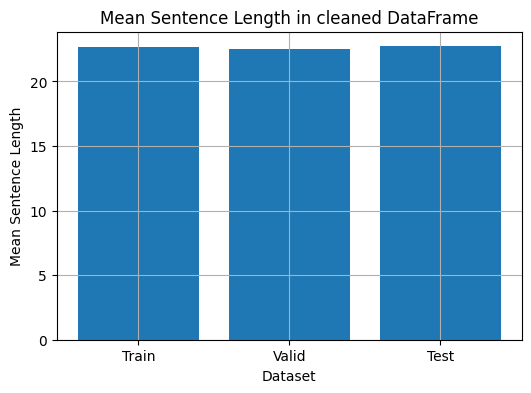

In [ ]:
def compute_mean_sentence_length(df_data):

    total_sentence_count = 0
    total_sentence_length = 0

    for line in df_data:
        sentences = line.split('.') 

        for sentence in sentences:
            tokens = sentence.strip().split() 
            sentence_length = len(tokens)

            if sentence_length > 0:
                total_sentence_count += 1
                total_sentence_length += sentence_length

    mean_sentence_length = total_sentence_length / total_sentence_count
    return mean_sentence_length

# Compute mean sentence length for each dataset
train_mean = compute_mean_sentence_length(train_df['text'])
valid_mean = compute_mean_sentence_length(valid_df['text'])
test_mean  = compute_mean_sentence_length(test_df['text'])

# Plot the results
datasets = ['Train', 'Valid', 'Test']
means = [train_mean, valid_mean, test_mean]

plt.figure(figsize=(6, 4))
plt.bar(datasets, means)
plt.xlabel('Dataset')
plt.ylabel('Mean Sentence Length')
plt.title('Mean Sentence Length in cleaned DataFrame')
plt.grid(True)
plt.show()

#### 2. Analyze the most common and least common words in the dataset

In [ ]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

def find_common_words(df, column):

    # Load the English language model
    nlp = spacy.load('en_core_web_sm')

    # Combine all text in the specified column
    all_words = ' '.join(df[column]).split()

    # Remove stopwords using spaCy
    doc = nlp(' '.join(all_words))
    filtered_words = [token.text for token in doc if not token.is_stop]

    # Compute word frequencies
    word_counter = Counter(filtered_words)

    # Find the 10 most common words
    most_common_words = word_counter.most_common(10)
    most_common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

    # Find the 10 least common words
    least_common_words = word_counter.most_common()[:-11:-1]
    least_common_words_df = pd.DataFrame(least_common_words, columns=['Word', 'Frequency'])

    # Plot word frequencies
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].bar(most_common_words_df['Word'], most_common_words_df['Frequency'])
    axs[0].set_title('Most Common Words')
    axs[0].set_xlabel('Word')
    axs[0].set_ylabel('Frequency')
    axs[0].tick_params(axis='x', rotation=45)

    axs[1].bar(least_common_words_df['Word'], least_common_words_df['Frequency'])
    axs[1].set_title('Least Common Words')
    axs[1].set_xlabel('Word')
    axs[1].set_ylabel('Frequency')
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return most_common_words_df, least_common_words_df

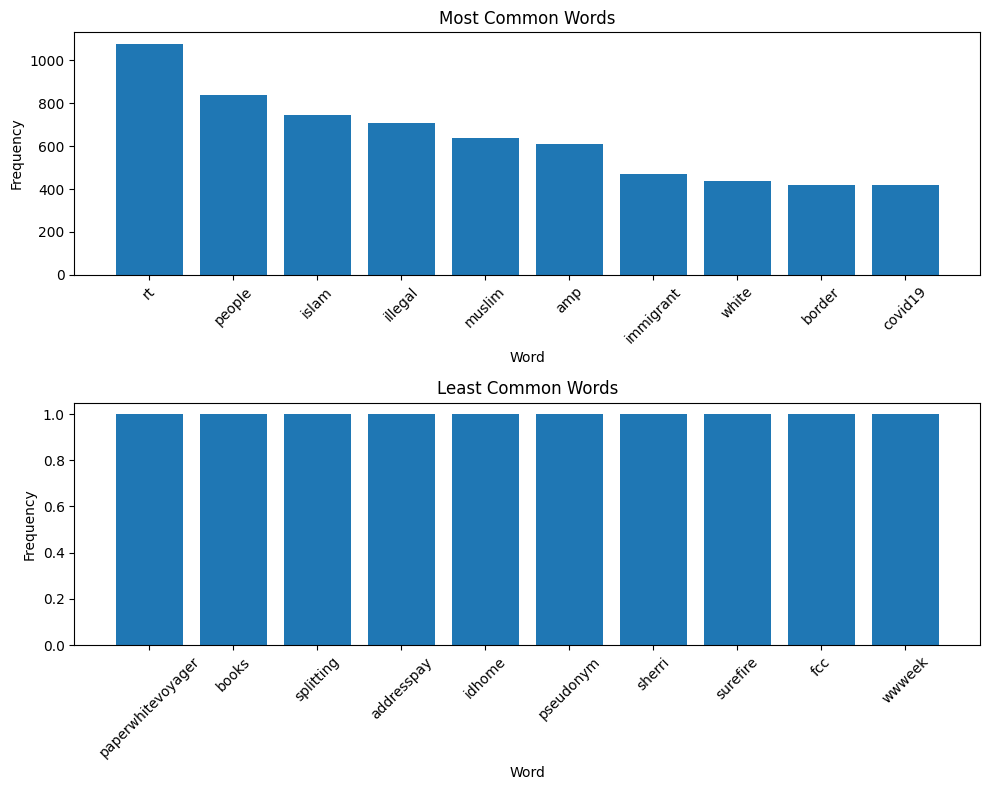

In [ ]:
# call the function
find_common_words(cleaned_df, 'text');

#### 3. Count the number of words that repeat 3, 4, and 5 times in the training dataset

In [ ]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

# Compute word frequencies in the DataFrame
freqs = Counter()

for text in cleaned_df['text']:
    # Tokenize the text using spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Update the word frequencies
    freqs.update(tokens)

# Count the number of words that repeat 3, 4, and 5 times
count_3 = count_4 = count_5 = 0
for word, freq in freqs.items():
    if freq == 3:
        count_3 += 1
    elif freq == 4:
        count_4 += 1
    elif freq == 5:
        count_5 += 1

print(f"Number of words that appear 3 times: {count_3}")
print(f"Number of words that appear 4 times: {count_4}")
print(f"Number of words that appear 5 times: {count_5}")

Number of words that appear 3 times: 692
Number of words that appear 4 times: 447
Number of words that appear 5 times: 308


#### 4. Word Length Distribution

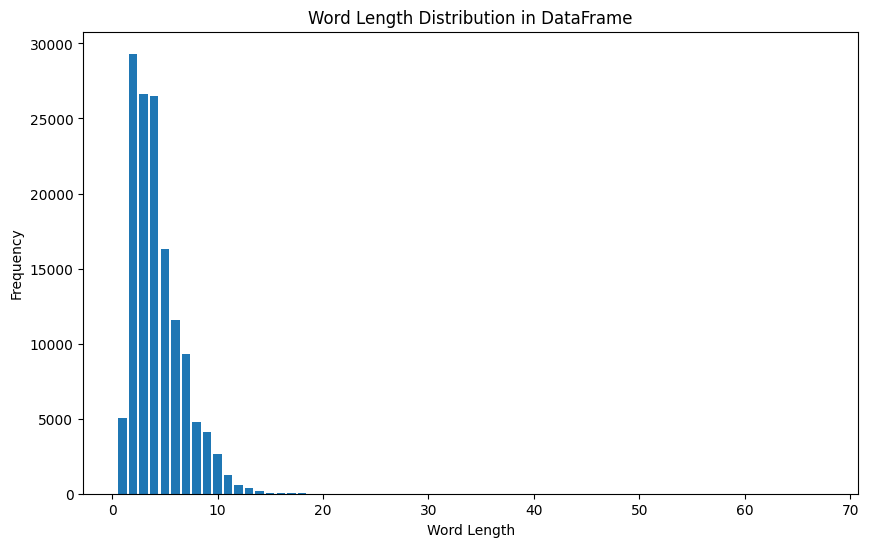

In [ ]:
import spacy
import matplotlib.pyplot as plt
from collections import Counter

nlp = spacy.load('en_core_web_sm')
text_data = cleaned_df['text']

# tokenizer function using spaCy
def tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc]

# Compute the word lengths in the DataFrame
word_lengths = []
for text in text_data:
    tokens = tokenizer(text)
    word_lengths.extend(len(word) for word in tokens)

# Create a frequency distribution of word lengths
word_length_counts = Counter(word_lengths)

# Plot the word length distribution
plt.figure(figsize=(10, 6))
plt.bar(word_length_counts.keys(), word_length_counts.values())
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.title("Word Length Distribution in DataFrame")
plt.show()

#### 5. Explore Part-of-Speech (POS) Tagging

Most Common Part-of-Speech Tags:
NOUN: 29688
VERB: 17926
PRON: 13500
ADP: 12986
ADJ: 12156
DET: 9974
PROPN: 9448
AUX: 8208
ADV: 5988
SPACE: 4592


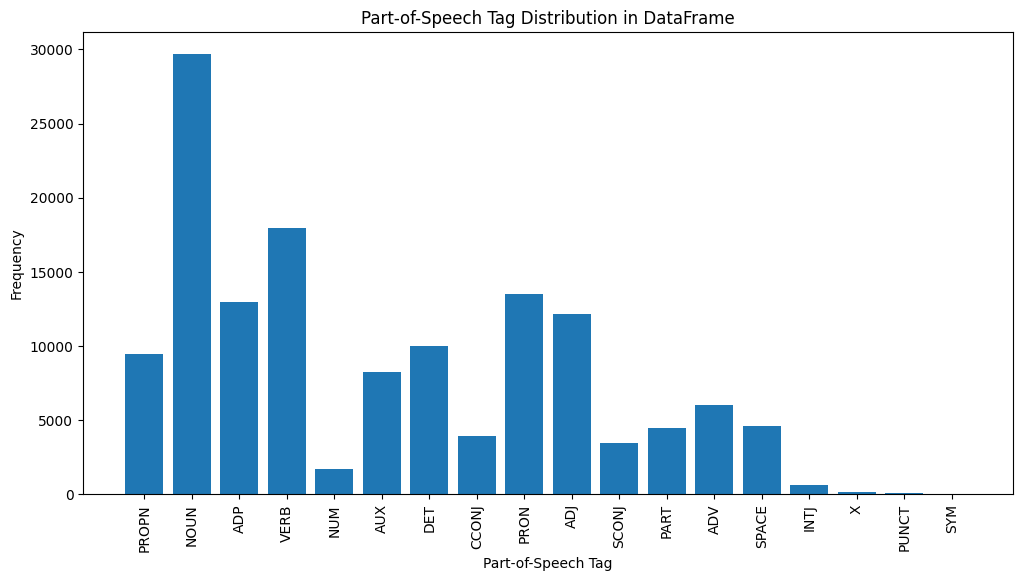

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

nlp = spacy.load("en_core_web_sm")
text_data = cleaned_df['text']

# tokenizer function using spaCy
def tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc]

# Perform POS tagging on the DataFrame
pos_tags = []
for text in text_data:
    tokens = tokenizer(text)
    doc = nlp(" ".join(tokens))
    pos_tags.extend([(token.text, token.pos_) for token in doc])

# Count the frequency of each POS tag
pos_tag_counts = Counter(tag for _, tag in pos_tags)

# Print the most common POS tags
print("Most Common Part-of-Speech Tags:")
for tag, count in pos_tag_counts.most_common(10):
    print(f"{tag}: {count}")

# Visualize the POS tag distribution
plt.figure(figsize=(12, 6))
plt.bar(pos_tag_counts.keys(), pos_tag_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Part-of-Speech Tag")
plt.ylabel("Frequency")
plt.title("Part-of-Speech Tag Distribution in DataFrame")
plt.show()

#### 6. Named Entity Distribution in DataFrame

Most Common Named Entity Types:
NORP: 2274
CARDINAL: 1052
GPE: 940
PERSON: 772
DATE: 650
ORG: 316
ORDINAL: 133
LOC: 93
TIME: 93
QUANTITY: 23


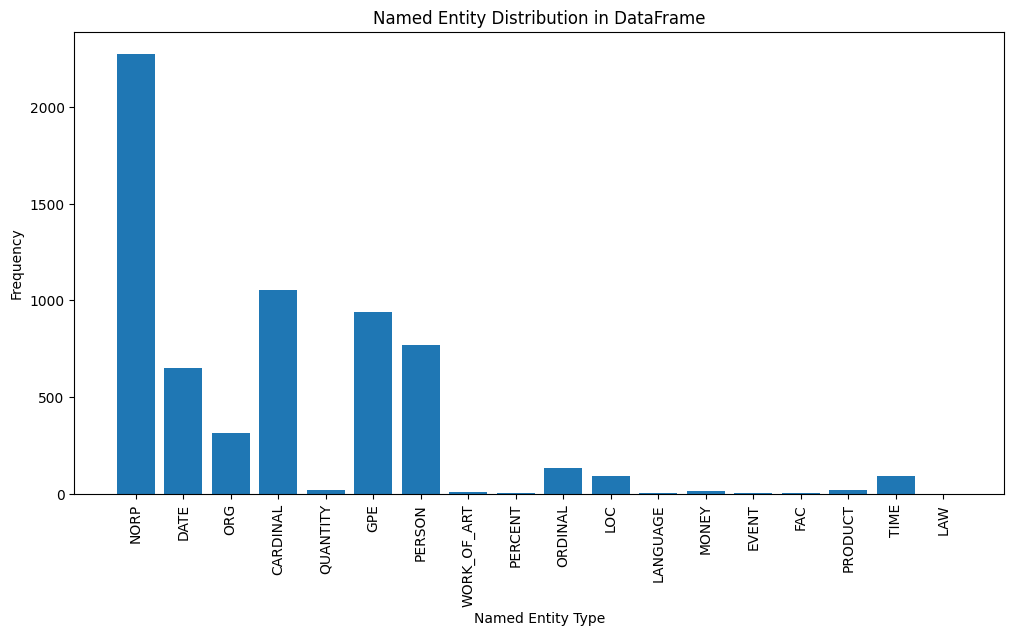

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

nlp = spacy.load("en_core_web_sm")
text_data = cleaned_df['text']

# tokenizer
def tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc]

# Perform NER on the DataFrame
named_entities = []
for text in text_data:
    tokens = tokenizer(text)
    doc = nlp(" ".join(tokens))
    named_entities.extend([(ent.text, ent.label_) for ent in doc.ents])

# Count the frequency of each named entity type
ner_counts = Counter(label for _, label in named_entities)

# Print the most common named entity types
print("Most Common Named Entity Types:")
for label, count in ner_counts.most_common(10):
    print(f"{label}: {count}")

# Visualize the named entity distribution
plt.figure(figsize=(12, 6))
plt.bar(ner_counts.keys(), ner_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Named Entity Type")
plt.ylabel("Frequency")
plt.title("Named Entity Distribution in DataFrame")
plt.show()

#### 7. Word Cloud

##### 7-1. Word Cloud for the `racism` dataset

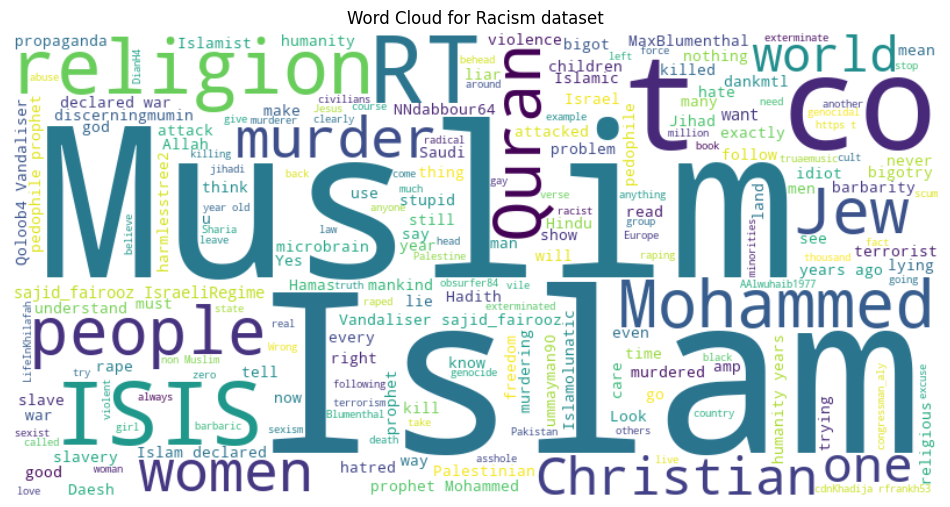

In [ ]:
# For racism dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_racism = pd.read_csv('racism_df.csv')
df_racism = df_racism.rename(columns={'Text': 'text'})
text_data = df_racism['text']

# Create a string from the entire DataFrame text
text = " ".join(text_data)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Racism dataset')
plt.show()

##### 7-2. Word Cloud for the `xenophobia` Dataset

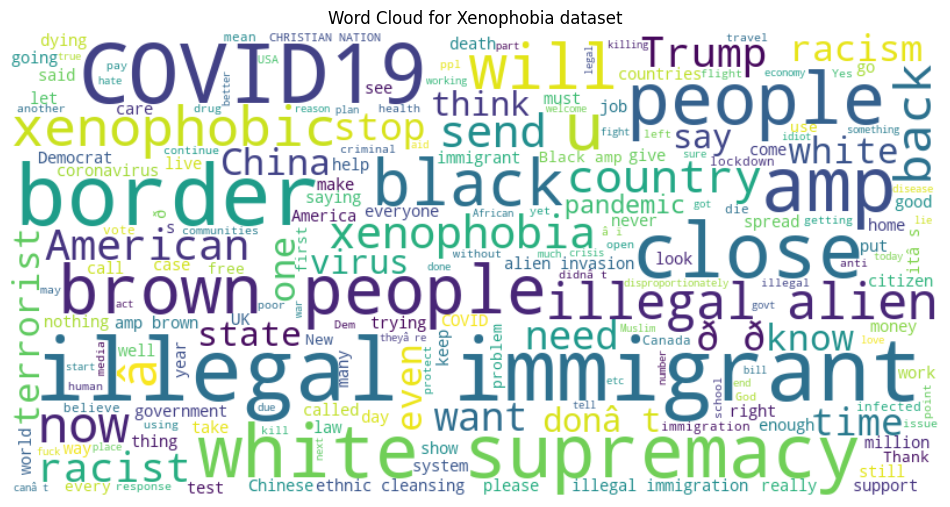

In [ ]:
# For xenophobia dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_xeno = pd.read_csv('xenophobic_df.csv')
text_data = df_xeno['text']

# Create a string from the entire DataFrame text
text = " ".join(text_data)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Xenophobia dataset')
plt.show()

##### 7-3. Word Cloud for the `non-hate` Dataset

In [ ]:
df_neutral = pd.read_csv('non-hate.csv')
df_neutral = df_neutral.rename(columns={"Text": "text"})

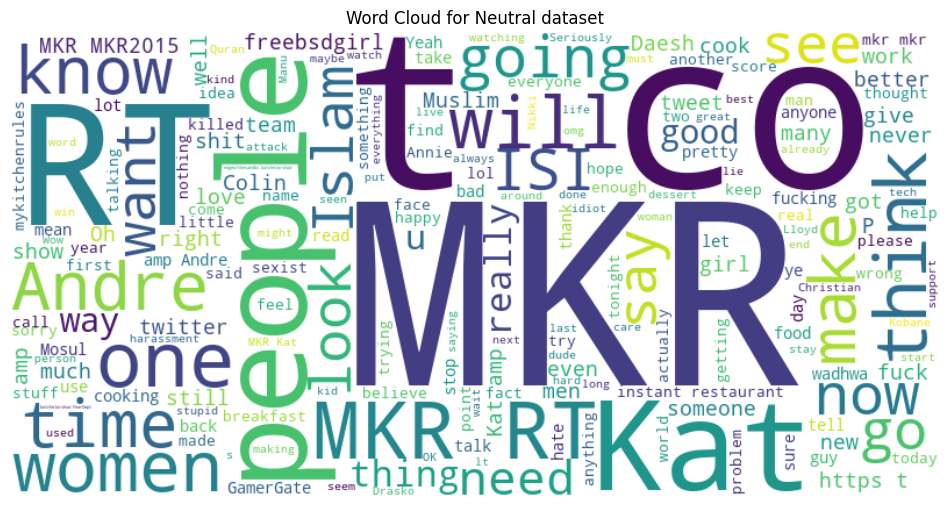

In [ ]:
# For non-hate dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = df_neutral['text']

# Create a string from the entire DataFrame text
text = " ".join(text_data)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-hate dataset')
plt.show()

#### 8. Clustering Words by Semantic Similarity and Visualizing Word Clouds

/home/ebrahim/miniconda3/envs/pytorch23/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


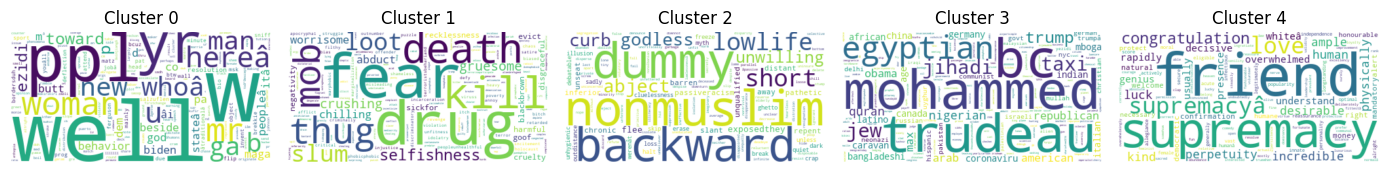

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Read clean data
text_data = cleaned_df['text']

# Load the BERT-based sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Compute the BERT embeddings for each unique word in the dataset
unique_words = set(' '.join(text_data).split())
word_embeddings = model.encode(list(unique_words))

# Cluster the words using K-Means
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(word_embeddings)

# Group the words by cluster
word_clusters = defaultdict(list)
for i, word in enumerate(unique_words):
    word_clusters[clusters[i]].append(word)

# Create a word cloud for each cluster
fig, axes = plt.subplots(1, 5, figsize=(14, 12))
axes = axes.flatten()

for cluster_id, cluster_words in word_clusters.items():
    word_cloud = WordCloud(width=400, height=200, background_color='white').generate(' '.join(cluster_words))
    axes[cluster_id].imshow(word_cloud, interpolation='bilinear')
    axes[cluster_id].set_title(f"Cluster {cluster_id}")
    axes[cluster_id].axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

plt.tight_layout()
plt.show()

# Custom Dataset and DataLoader

In [6]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

/home/ebrahim/miniconda3/envs/pytorch23/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=64):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text = row['text']
        label = row['target']

        # Debugging statements
        if not isinstance(text, str):
            raise ValueError(f"Expected text to be a string, but got {type(text)}")

        # Tokenize the text
        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids = encoded['input_ids'].squeeze()
        attention_mask = encoded['attention_mask'].squeeze()
        label = torch.tensor(label, dtype=torch.long)

        return input_ids, attention_mask, label


# Function to create DataLoader
def create_data_loader(df, tokenizer, batch_size, max_length):
    dataset = CustomDataset(df, tokenizer, max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Load Pretrained Model (`roberta-hate-speech`)

In [8]:
checkpoint = 'facebook/roberta-hate-speech-dynabench-r4-target'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=64)
config = AutoConfig.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.classifier.out_proj = nn.Linear(model.classifier.out_proj.in_features, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/ebrahim/miniconda3/envs/pytorch23/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [9]:
config

RobertaConfig {
  "_name_or_path": "facebook/roberta-hate-speech-dynabench-r4-target",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "nothate",
    "1": "hate"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": null,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.41.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

# Train loop

In [11]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_pretrained_model(checkpoint):
    config = AutoConfig.from_pretrained(checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
    model.classifier.out_proj = nn.Linear(model.classifier.out_proj.in_features, 3)
    return model

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []

    for inputs, attention_mask, labels in tqdm(train_loader, desc="Training", unit="batch"):
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    loss = running_loss / len(train_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return loss, acc, f1

def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, attention_mask, labels in tqdm(valid_loader, desc="Validation", unit="batch"):
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(inputs, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    
    loss = running_loss / len(valid_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return loss, acc, f1

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
def fine_tune_model(model, train_loader, valid_loader, num_epochs, device, model_save_path, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    best_f1 = 0
    best_model = model

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    # TensorBoard writer
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        valid_loss, valid_acc, valid_f1 = validate(model, valid_loader, criterion, device)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Train F1: {train_f1:.3f}")
        print(f"Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f},  Valid F1: {valid_f1:.3f}")

        # Log to TensorBoard
        writer.add_scalar('Train/Loss', train_loss, epoch)
        writer.add_scalar('Train/Acc', train_acc, epoch)
        writer.add_scalar('Train/F1', train_f1, epoch)
        writer.add_scalar('Validation/Loss', valid_loss, epoch)
        writer.add_scalar('Validation/Acc', valid_acc, epoch)
        writer.add_scalar('Validation/F1', valid_f1, epoch)

        if valid_f1 > best_f1:
            best_f1 = valid_f1
            best_model = model
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved with F1: {best_f1:.4f}")
            print(60 * '*')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
    
    # Plotting the loss curves after all epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o', color='b')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss', marker='x', color='r')
    plt.title('Loss Monitoring During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o', color='b')
    plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy', marker='x', color='r')
    plt.title('Accuracy Monitoring During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    writer.close()
    best_model.load_state_dict(torch.load(model_save_path))
    best_model.eval()

    return best_model

ModuleNotFoundError: No module named 'tensorboard'

In [12]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_pretrained_model(checkpoint):
    config = AutoConfig.from_pretrained(checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
    model.classifier.out_proj = nn.Linear(model.classifier.out_proj.in_features, 3)
    return model

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    y_true, y_pred = [], []

    for inputs, attention_mask, labels in tqdm(train_loader, desc="Training", unit="batch"):
        inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    loss = running_loss / len(train_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return loss, acc, f1

def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, attention_mask, labels in tqdm(valid_loader, desc="Validation", unit="batch"):
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(inputs, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    plot_confusion_matrix(y_true, y_pred)

    loss = running_loss / len(valid_loader)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return loss, acc, f1

ModuleNotFoundError: No module named 'tensorboard'

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR


def fine_tune_model(model, train_loader, valid_loader, num_epochs, device, model_save_path, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    best_f1 = 0
    best_model = model

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    # TensorBoard writer
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        valid_loss, valid_acc, valid_f1 = validate(model, valid_loader, criterion, device)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Train F1: {train_f1:.3f}")
        print(f"Valid Loss: {valid_loss:.3f}, Valid Acc: {valid_acc:.3f},  Valid F1: {valid_f1:.3f}")

        # Log to TensorBoard
        writer.add_scalar('Train/Loss', train_loss, epoch)
        writer.add_scalar('Train/Acc', train_acc, epoch)
        writer.add_scalar('Train/F1', train_f1, epoch)
        writer.add_scalar('Validation/Loss', valid_loss, epoch)
        writer.add_scalar('Validation/Acc', valid_acc, epoch)
        writer.add_scalar('Validation/F1', valid_f1, epoch)

        if valid_f1 > best_f1:
            best_f1 = valid_f1
            best_model = model
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved with F1: {best_f1:.4f}")
            print(60 * '*')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
    
    # Plotting the loss curves after all epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss', marker='o', color='b')
    plt.plot(range(1, epoch + 2), valid_losses, label='Valid Loss', marker='x', color='r')
    plt.title('Loss Monitoring During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), train_accuracies, label='Train Accuracy', marker='o', color='b')
    plt.plot(range(1, epoch + 2), valid_accuracies, label='Valid Accuracy', marker='x', color='r')
    plt.title('Accuracy Monitoring During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    writer.close()
    best_model.load_state_dict(torch.load(model_save_path))
    best_model.eval()

    return best_model

## Hyperparameter Tuning

### Step 1: Try to train and Overfit the model on a small subset of the dataset.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = 'facebook/roberta-hate-speech-dynabench-r4-target'
model = load_pretrained_model(checkpoint).to(device)

# A subset of dataset
train_subset = train_df.sample(n=16, random_state=42)
valid_subset = valid_df.sample(n=8, random_state=42)

batch_size = 8

train_loader = create_data_loader(train_subset, tokenizer, batch_size=batch_size, max_length=64)
valid_loader = create_data_loader(valid_subset, tokenizer, batch_size=batch_size, max_length=64)

num_epochs = 10
model_save_path = 'best_model.pth'
lr = 1e-4
best_model = fine_tune_model(model, train_loader, valid_loader, num_epochs, device, model_save_path, lr=lr)

### Step 2: Try to train a subset of data with different learning rate to find the best lr

In [ ]:
checkpoint = 'facebook/roberta-hate-speech-dynabench-r4-target'
model = load_pretrained_model(checkpoint).to(device)

# A subset of dataset
train_subset = train_df.sample(n=16, random_state=42)
valid_subset = valid_df.sample(n=8, random_state=42)

batch_size = 8

train_loader = create_data_loader(train_subset, tokenizer, batch_size=batch_size, max_length=64)
valid_loader = create_data_loader(valid_subset, tokenizer, batch_size=batch_size, max_length=64)

learning_rates = [2e-3, 2e-4, 2e-5]

# Iterate over each learning rate
for lr in learning_rates:
    print(f"Training model with learning rate: {lr} \n")
    num_epochs = 5
    model_save_path = 'best_model.pth'
    best_model = fine_tune_model(model, train_loader, valid_loader, num_epochs, device, model_save_path, lr=lr)

# Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = 'facebook/roberta-hate-speech-dynabench-r4-target'
model = load_pretrained_model(checkpoint).to(device)

batch_size = 16
num_epochs = 30

train_loader = create_data_loader(train_df, tokenizer, batch_size=batch_size, max_length=64)
valid_loader = create_data_loader(valid_df, tokenizer, batch_size=batch_size, max_length=64)
test_loader = create_data_loader(test_df, tokenizer, batch_size=batch_size, max_length=64)

model_save_path = 'best_model.pth'
best_model = fine_tune_model(model, train_loader, valid_loader, num_epochs, device, model_save_path)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/runs

## Evaluation on specific input texts

In [ ]:
import torch
import torch.nn.functional as F

def evaluate_single_text(model, tokenizer, text, device, max_length=64):
    model.eval()

    # Tokenize the text
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # model prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    # predicted class
    predicted_class = torch.argmax(logits, dim=1).cpu().numpy()[0]
    probabilities = F.softmax(logits, dim=1)[0]
    return predicted_class, probabilities

# Mapping the output classes to their corresponding labels
label_mapping = {0: "no-hate",
                 1: "racism",
                 2: "xenophobia"}

def evaluate_texts(trained_model, tokenizer, texts, device, max_length=64):
    predictions = {}

    for text in texts:
        predicted_class, probabilities = evaluate_single_text(trained_model, tokenizer, text, device, max_length)
        category = label_mapping[predicted_class]
        predictions[text] = (category, probabilities)

    return predictions

Text: Muslims are taking all the jobs.
Category: racism
	Probability of racism: 0.9902
	Probability of no-hate: 0.0057
	Probability of xenophobia: 0.0040

Text: The government should deport all immigrants and protect our country from outsiders.
Category: xenophobia
	Probability of xenophobia: 0.9799
	Probability of racism: 0.0154
	Probability of no-hate: 0.0047

Text: It is a sunny day.
Category: no-hate
	Probability of no-hate: 0.9981
	Probability of racism: 0.0012
	Probability of xenophobia: 0.0006



In [ ]:
# Example texts for testing
texts = [
    "Muslims are taking all the jobs.",
    "The government should deport all immigrants and protect our country from outsiders.",
    "It is a sunny day."
    ]

# Trained model and a tokenizer
model_save_path = '/content/best_model.pth'
best_model.load_state_dict(torch.load(model_save_path))

# Evaluate the texts
predictions = evaluate_texts(best_model, tokenizer, texts, device, max_length=64)

# Print the predictions
for text, (category, probabilities) in predictions.items():
    print(f"Text: {text}\nCategory: {category}")
    sorted_probs = sorted(zip(label_mapping.values(), probabilities.cpu().numpy()), key=lambda x: x[1], reverse=True)
    for label, prob in sorted_probs:
        print(f"\tProbability of {label}: {prob:.4f}")
    print()


## Evaluation Code fot test dataset

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, attention_mask, labels in tqdm(data_loader, desc="Evaluation", unit="batch"):
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(inputs, attention_mask=attention_mask).logits
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=['no-hate', 'racism', 'xenophobia'])

    print("Evaluation Results:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(60 * '*')
    print("Confusion Matrix:")
    print(cm)
    print(60 * '*')
    print("Classification Report:")
    print(report)

# load best model
model_save_path = '/content/best_model.pth'
best_model.load_state_dict(torch.load(model_save_path))

evaluate_model(best_model, test_loader, device)

Evaluation: 100%|██████████| 112/112 [00:03<00:00, 29.77batch/s]

Evaluation Results:
F1 Score: 0.9139
Accuracy: 0.9135
************************************************************
Confusion Matrix:
[[254  43   2]
 [ 27 269   2]
 [  0   3 290]]
************************************************************
Classification Report:
              precision    recall  f1-score   support

     no-hate       0.90      0.85      0.88       299
      racism       0.85      0.90      0.88       298
  xenophobia       0.99      0.99      0.99       293

    accuracy                           0.91       890
   macro avg       0.91      0.91      0.91       890
weighted avg       0.91      0.91      0.91       890

